# **IMPORTING LIBRARIES AND DEFINING FUNCTIONS**

In [1]:
# --- Install Necessary Libraries ---
!pip install lime shap mlxtend imbalanced-learn --quiet
!pip install --quiet gdown

# --- Standard Libraries ---
import math
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import gdown

# --- Colab Specific ---
from google.colab import drive, files
from IPython.display import HTML, display

# --- Scikit-learn Preprocessing ---
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder

# --- Scikit-learn Model Selection ---
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV,
    cross_val_score, learning_curve
)

# --- Scikit-learn Metrics ---
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, roc_curve, auc
)

# --- Scikit-learn Feature Selection & Inspection ---
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance

# --- Scikit-learn Models ---
from sklearn.linear_model import (
    LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier,
    RidgeClassifier, RidgeClassifierCV
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# --- XGBoost ---
from xgboost import XGBClassifier

# --- Visualization Enhancements ---
from mlxtend.plotting import plot_confusion_matrix

# --- Additional Metrics ---
from imblearn.metrics import specificity_score

# --- Explainability Libraries ---
import lime
import lime.lime_tabular
import shap




def explain_lime(model, model_name, data, idx=0):
    print(f"\nLIME explanation for {model_name}, instance {idx}")
    exp = explainer_lime.explain_instance(
        data_row=data[idx],
        predict_fn=model.predict_proba
    )
    display(exp.show_in_notebook(show_table=True))

# **DATA FETCHING AND SHUFFLING**

In [2]:
# Google Drive file ID extracted from your shared link
file_id = '1C8TINozW_d0ArNP96kyJg54AWZ2vSQNx'

# Local path to save the downloaded CSV
output_path = '/content/Combined.csv'

# Download the file using gdown (handles large files and warnings automatically)
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)

list_of_dfs_to_combine = []

try:
    # Read the downloaded CSV file
    current_df = pd.read_csv(output_path)
    list_of_dfs_to_combine.append(current_df)
except pd.errors.EmptyDataError:
    print("WARNING: The downloaded file is empty. Skipping it.")
except Exception as e:
    print(f"ERROR loading CSV data: {e}")

if list_of_dfs_to_combine:
    combined_df = pd.concat(list_of_dfs_to_combine, ignore_index=True)
    shuffled_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"Final combined and shuffled DataFrame shape: {shuffled_df.shape}")
    print("\nFirst 5 rows of the shuffled DataFrame:")
    print(shuffled_df.head())
else:
    print("\nNo data was loaded or combined. Check the link or your internet connection.")

Downloading...
From (original): https://drive.google.com/uc?id=1C8TINozW_d0ArNP96kyJg54AWZ2vSQNx
From (redirected): https://drive.google.com/uc?id=1C8TINozW_d0ArNP96kyJg54AWZ2vSQNx&confirm=t&uuid=d49dc88d-f6c0-4c8e-871b-c49cac9bc9db
To: /content/Combined.csv
100%|██████████| 275M/275M [00:03<00:00, 79.1MB/s]
/tmp/ipython-input-2-2246355372.py:14: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  current_df = pd.read_csv(output_path)


Final combined and shuffled DataFrame shape: (1215890, 52)

First 5 rows of the shuffled DataFrame:
   Unnamed: 0    Seq       Dur   RunTime      Mean       Sum       Min  \
0      145666  63336  2.573265  2.573265  2.573265  2.573265  2.573265   
1      617114  19483  1.483689  1.483689  1.483689  1.483689  1.483689   
2      146518  51371  2.577294  2.577294  2.577294  2.577294  2.577294   
3      337428   2580  0.000000  0.000000  0.000000  0.000000  0.000000   
4      148035  33737  0.000000  0.000000  0.000000  0.000000  0.000000   

        Max Proto  sTos  ...   sVid dVid   SrcTCPBase    DstTCPBase    TcpRtt  \
0  2.573265   udp   0.0  ...    NaN  NaN          NaN           NaN  0.000000   
1  1.483689   tcp   0.0  ...    NaN  NaN  723425341.0  4.153227e+09  0.017114   
2  2.577294   udp   0.0  ...    NaN  NaN          NaN           NaN  0.000000   
3  0.000000   udp   0.0  ...  610.0  NaN          NaN           NaN  0.000000   
4  0.000000   udp   0.0  ...    NaN  NaN          

# **DATA PARTICION**

In [3]:

# >  Defines configuration variables
sample_fraction = 1/60
random_seed = 42
ATTACK_TYPE_COLUMN = 'Attack Type'
DOS_ATTACK_LABELS = ['UDPFlood', 'SYNFlood', 'HTTPFlood', 'SlowrateDoS']

# > Balancing dataset, cleaning non-DoS attacks and one-hot encoding features
if shuffled_df.shape[0] > 0:
    total_samples_desired = int(shuffled_df.shape[0] * sample_fraction)
    if total_samples_desired == 0 and shuffled_df.shape[0] > 0:
        total_samples_desired = 1

    desired_normal_proportion = 0.9
    desired_malicious_proportion = 0.1

    normal_traffic_df = shuffled_df[shuffled_df['Label'] == 'Benign']

    if ATTACK_TYPE_COLUMN in shuffled_df.columns:
        malicious_traffic_df = shuffled_df[
            (shuffled_df['Label'] == 'Malicious') &
            (shuffled_df[ATTACK_TYPE_COLUMN].isin(DOS_ATTACK_LABELS))
        ]
        if malicious_traffic_df.empty:
            print(f"Warning: No DoS attacks found in the '{ATTACK_TYPE_COLUMN}' column with labels: {DOS_ATTACK_LABELS}. Malicious samples might be empty.")
    else:
        print(f"ERROR: Attack type column '{ATTACK_TYPE_COLUMN}' not found. Cannot filter for DoS attacks. Proceeding with all malicious traffic.")
        malicious_traffic_df = shuffled_df[shuffled_df['Label'] == 'Malicious']

    target_normal_samples = int(total_samples_desired * desired_normal_proportion)
    target_malicious_samples = total_samples_desired - target_normal_samples

    sampled_normal = normal_traffic_df.sample(
        n=min(target_normal_samples, len(normal_traffic_df)),
        random_state=random_seed
    )
    sampled_malicious = malicious_traffic_df.sample(
        n=min(target_malicious_samples, len(malicious_traffic_df)),
        random_state=random_seed
    )

    sampled_df = pd.concat([sampled_normal, sampled_malicious]).sample(frac=1, random_state=random_seed).reset_index(drop=True)

    if not sampled_df.empty:
        print(f"Sampled data to {sampled_df.shape[0]} rows (targeting 70% Benign, 30% Malicious DoS attacks).")
        final_proportions = sampled_df['Label'].value_counts(normalize=True)
        if (abs(final_proportions.get('Benign', 0) - desired_normal_proportion) > 0.01 or
            abs(final_proportions.get('Malicious', 0) - desired_malicious_proportion) > 0.01):
            print("Note: Exact 70/30 Benign/Malicious split could not be achieved due to data limitations.")
    else:
        print("No data sampled as categories might be empty or insufficient.")
else:
    sampled_df = pd.DataFrame()
    print("No data in shuffled_df to sample.")

Sampled data to 20264 rows (targeting 70% Benign, 30% Malicious DoS attacks).


# **CORRELATION**

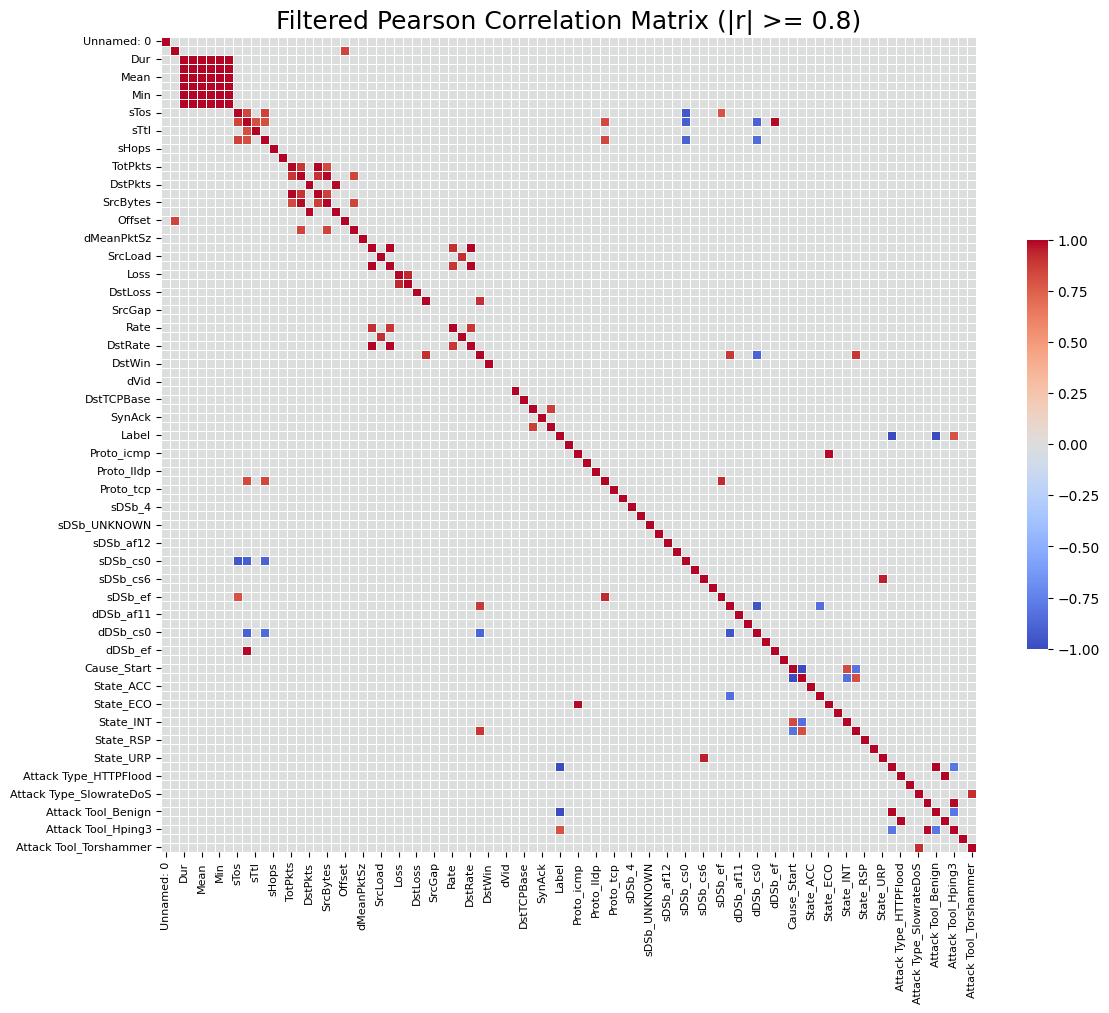

In [4]:
if not sampled_df.empty:
    df_corr = sampled_df.copy()

    # Map Label to numeric
    df_corr['Label'] = df_corr['Label'].map({'Benign': 0, 'Malicious': 1})

    # Identify columns to encode: all object/string columns except 'Label'
    categorical_cols = df_corr.select_dtypes(include=['object']).columns.tolist()
    if 'Label' in categorical_cols:
        categorical_cols.remove('Label')

    # One-Hot Encode all categorical columns at once
    if categorical_cols:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        ohe_data = ohe.fit_transform(df_corr[categorical_cols].fillna('UNKNOWN'))
        ohe_cols = ohe.get_feature_names_out(categorical_cols)

        # Build a dataframe of encoded features
        df_ohe = pd.DataFrame(ohe_data, columns=ohe_cols, index=df_corr.index)

        # Drop original categorical columns and add the encoded ones
        df_corr = df_corr.drop(columns=categorical_cols)
        df_corr = pd.concat([df_corr, df_ohe], axis=1)

    # Now df_corr should have only numeric columns (original numeric + one-hot encoded)
    corr_matrix = df_corr.corr()

    # Mask to show only lower triangle (optional but cleaner)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    threshold = 0.8
    mask_strong = (np.abs(corr_matrix) >= threshold)

    # Use this mask to zero-out weak correlations or keep only strong features
    filtered_corr = corr_matrix.where(mask_strong, other=0)

    plt.figure(figsize=(12, 10))
    sns.heatmap(filtered_corr, cmap='coolwarm', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Filtered Pearson Correlation Matrix (|r| >= 0.8)', fontsize=18)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    plt.close()

else:
    print("Sampled DataFrame is empty. Cannot compute correlation matrix.")

# **FEATURE SELECTION AND/OR GENERATION**







In [5]:
target_column_name = 'Label'

feature_columns = ['Cause', 'RunTime','TcpRtt','sMeanPktSz','sTtl','Load','SrcBytes', 'Offset', 'Proto']

#feature_columns = [
#    'Dur', 'RunTime', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos',
#    'sDSb', 'dDSb', 'sTtl', 'dTtl', 'sHops', 'dHops', 'Cause', 'TotPkts',
#    'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset',
#    'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss',
#    'SrcLoss', 'DstLoss', 'pLoss', 'SrcGap', 'DstGap', 'Rate', 'SrcRate',
#    'DstRate', 'State', 'SrcWin', 'DstWin', 'sVid', 'dVid', 'SrcTCPBase',
#    'DstTCPBase', 'TcpRtt', 'SynAck', 'AckDat'
#]


# **DATA PREPROCESSING**


In [6]:
nan_strategy = 'fillna_zero' # > Options: 'drop' or 'fillna_zero'

if not sampled_df.empty:
    # >  Displays the proportion of 'Malicious' and 'Benign' labels in the sampled data
    if 'Label' in sampled_df.columns:
        print("\nProportion of Malicious and Benign traffic in sampled_df:")
        print(sampled_df['Label'].value_counts(normalize=True))

    # > Maps the target column ('Label') from text to numerical (0 for Benign, 1 for Malicious)
    if target_column_name in sampled_df.columns:
        y_df_temp = sampled_df[target_column_name].map({'Benign': 0, 'Malicious': 1})
    # > Handles cases where the target column is missing
    else:
        print(f"ERROR: Target column '{target_column_name}' not found in sampled DataFrame.")
        y_df = pd.Series([], dtype=int)
        x_df = pd.DataFrame()

    # > Selects and preprocesses features for the model
    if all(col in sampled_df.columns for col in feature_columns):
        # > Creates a copy of the sampled features
        x_df_initial = sampled_df[feature_columns].copy()

        # > Creates a copy of the feature list to modify, preserving the original
        processed_feature_columns = feature_columns.copy()

        # > Initializes OneHotEncoder for categorical feature encoding
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

        # > Applies One-Hot Encoding to the 'Proto' column
        if 'Proto' in x_df_initial.columns:
            print(f"Codificando 'Proto' usando One-Hot Encoding...")
            proto_data = x_df_initial['Proto'].fillna('UNKNOWN').astype(str).values.reshape(-1, 1)
            proto_encoded = ohe.fit_transform(proto_data)
            proto_new_cols = ohe.get_feature_names_out(['Proto'])
            proto_df_encoded = pd.DataFrame(proto_encoded, columns=proto_new_cols, index=x_df_initial.index)
            x_df_initial = pd.concat([x_df_initial, proto_df_encoded], axis=1)
            x_df_initial = x_df_initial.drop('Proto', axis=1)
            print(f"Colunas de 'Proto' One-Hot Encoded adicionadas. Novas colunas: {proto_new_cols.tolist()}")
            # > Updates the *copied* feature_columns list with new encoded column names
            if 'Proto' in processed_feature_columns:
                processed_feature_columns.remove('Proto')
                processed_feature_columns.extend(proto_new_cols.tolist())
        else:
            print("'Proto' column not selected as a feature or not found, skipping encoding.")

        # > Applies One-Hot Encoding to the 'Cause' column
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        if 'Cause' in x_df_initial.columns:
            print(f"Codificando 'Cause' usando One-Hot Encoding...")
            cause_data = x_df_initial['Cause'].fillna('UNKNOWN').astype(str).values.reshape(-1, 1)
            cause_encoded = ohe.fit_transform(cause_data)
            cause_new_cols = ohe.get_feature_names_out(['Cause'])
            cause_df_encoded = pd.DataFrame(cause_encoded, columns=cause_new_cols, index=x_df_initial.index)
            x_df_initial = pd.concat([x_df_initial, cause_df_encoded], axis=1)
            x_df_initial = x_df_initial.drop('Cause', axis=1)
            print(f"Colunas de 'Cause' One-Hot Encoded adicionadas. Novas colunas: {cause_new_cols.tolist()}")
            # > Updates the *copied* feature_columns list with new encoded column names
            if 'Cause' in processed_feature_columns:
                processed_feature_columns.remove('Cause')
                processed_feature_columns.extend(cause_new_cols.tolist())
        else:
            print("'Cause' column not selected as a feature or not found, skipping encoding.")

        # > Applies One-Hot Encoding to the 'State' column
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        if 'State' in x_df_initial.columns:
            print(f"Codificando 'State' usando One-Hot Encoding...")
            state_data = x_df_initial['State'].fillna('UNKNOWN').astype(str).values.reshape(-1, 1)
            state_encoded = ohe.fit_transform(state_data)
            state_new_cols = ohe.get_feature_names_out(['State'])
            state_df_encoded = pd.DataFrame(state_encoded, columns=state_new_cols, index=x_df_initial.index)
            x_df_initial = pd.concat([x_df_initial, state_df_encoded], axis=1)
            x_df_initial = x_df_initial.drop('State', axis=1)
            print(f"Colunas de 'State' One-Hot Encoded adicionadas. Novas colunas: {state_new_cols.tolist()}")
            # Updates the *copied* feature_columns list with new encoded column names
            if 'State' in processed_feature_columns:
                processed_feature_columns.remove('State')
                processed_feature_columns.extend(state_new_cols.tolist())
        else:
            print("'State' column not selected as a feature or not found, skipping encoding.")

        # > Converts any remaining object-type columns to numeric, coercing errors to NaN
        for col in x_df_initial.columns:
            if x_df_initial[col].dtype == 'object':
                x_df_initial[col] = pd.to_numeric(x_df_initial[col], errors='coerce')

        # > Combines features and target for unified NaN handling
        combined_df = pd.concat([x_df_initial, y_df_temp.rename('__target__')], axis=1)

        # > Defines columns to check for NaN values
        cols_to_check_for_nan = [col for col in x_df_initial.columns if col in combined_df.columns] + ['__target__']

        initial_rows_count = combined_df.shape[0]

        # > Applies the chosen NaN handling strategy
        if nan_strategy == 'drop':
            combined_df_cleaned = combined_df.dropna(subset=cols_to_check_for_nan)
            rows_handled_count = initial_rows_count - combined_df_cleaned.shape[0]
            if rows_handled_count > 0:
                print(f"Dropped {rows_handled_count} rows due to NaN values in features or target (strategy: '{nan_strategy}').")
            else:
                print(f"No rows dropped due to NaN values (strategy: '{nan_strategy}').")
        elif nan_strategy == 'fillna_zero':
            # > Fill NaNs only in the relevant columns
            combined_df_cleaned = combined_df.copy() # > Work on a copy
            for col in cols_to_check_for_nan:
                if col in combined_df_cleaned.columns:
                    # > Only fill if column contains NaNs and is numeric or can be treated as such
                    if pd.api.types.is_numeric_dtype(combined_df_cleaned[col]) or pd.api.types.is_object_dtype(combined_df_cleaned[col]):
                        nan_count_in_col = combined_df_cleaned[col].isna().sum()
                        if nan_count_in_col > 0:
                            combined_df_cleaned[col] = combined_df_cleaned[col].fillna(0)
                            print(f"Filled {nan_count_in_col} NaN values in column '{col}' with 0 (strategy: '{nan_strategy}').")
            rows_handled_count = initial_rows_count - combined_df_cleaned.shape[0] # > Should be 0 for fillna
            if rows_handled_count == 0:
                print(f"NaN values replaced with 0 in specified columns (strategy: '{nan_strategy}'). No rows dropped.")
            else:
                print(f"Note: Some rows might have been dropped by previous steps or issues. {rows_handled_count} rows were affected.")
        else:
            print(f"Error: Invalid 'nan_strategy' specified: '{nan_strategy}'. No NaN handling applied.")
            combined_df_cleaned = combined_df.copy() # > Proceed with original combined_df

        # > Separates features (X) and target (y) again after cleaning
        x_df = combined_df_cleaned.drop(columns=['__target__'])
        y_df = combined_df_cleaned['__target__']

    # > Handles cases where selected initial feature columns are missing
    else:
        print(f"ERROR: One or more initial feature columns {feature_columns} not found in sampled DataFrame.")
        x_df = pd.DataFrame()
        y_df = pd.Series([], dtype=int)

    # > Splits data into training and testing sets, then scales features
    if not x_df.empty and not y_df.empty and x_df.shape[0] == y_df.shape[0]:
        X_train, X_test, y_train, y_test = train_test_split(
            x_df, y_df,
            test_size=0.30,
            random_state=random_seed,
            stratify=y_df # > Ensures proportional representation of target classes in splits
            )

       # > Initializes and applies StandardScaler to features
        scaler = StandardScaler()
        if X_train.shape[1] > 0: # Checks if there are columns to scale
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            # > Converts scaled arrays back to DataFrames with original column names
            X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
            X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
        else:
            print("WARNING: X_train has no columns to scale. Skipping scaling.")
            X_train_scaled_df = pd.DataFrame()
            X_test_scaled_df = pd.DataFrame()

        # > Prints shapes and label proportions of training and testing sets
        print(f"Shape of X_train: {X_train_scaled_df.shape}")
        print(f"Shape of y_train: {y_train.shape}")
        if not y_train.empty:
            print("\nProportion of Malicious (1) and Benign (0) traffic in y_train:")
            print(y_train.value_counts(normalize=True))

        print(f"Shape of X_test: {X_test_scaled_df.shape}")
        print(f"Shape of y_test: {y_test.shape}")
        if not y_test.empty:
            print("\nProportion of Malicious (1) and Benign (0) traffic in y_test:")
            print(y_test.value_counts(normalize=True))

    # > Handles issues with data alignment or emptiness before splitting
    else:
        print("X, y, or their alignment is problematic after feature/target extraction and zero drops. Cannot split.")
# > Handles case where the initial sampled DataFrame is empty
else:
    print("Sampled DataFrame is empty. Cannot proceed with feature/target extraction or splitting.")



Proportion of Malicious and Benign traffic in sampled_df:
Label
Benign       0.89997
Malicious    0.10003
Name: proportion, dtype: float64
Codificando 'Proto' usando One-Hot Encoding...
Colunas de 'Proto' One-Hot Encoded adicionadas. Novas colunas: ['Proto_arp', 'Proto_icmp', 'Proto_llc', 'Proto_lldp', 'Proto_sctp', 'Proto_tcp', 'Proto_udp']
Codificando 'Cause' usando One-Hot Encoding...
Colunas de 'Cause' One-Hot Encoded adicionadas. Novas colunas: ['Cause_Shutdown', 'Cause_Start', 'Cause_Status']
'State' column not selected as a feature or not found, skipping encoding.
Filled 7 NaN values in column 'sTtl' with 0 (strategy: 'fillna_zero').
NaN values replaced with 0 in specified columns (strategy: 'fillna_zero'). No rows dropped.
Shape of X_train: (14184, 17)
Shape of y_train: (14184,)

Proportion of Malicious (1) and Benign (0) traffic in y_train:
__target__
0    0.899958
1    0.100042
Name: proportion, dtype: float64
Shape of X_test: (6080, 17)
Shape of y_test: (6080,)

Proportion 



# **MODEL TRAINING**

In [7]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LogisticRegressionCV': LogisticRegressionCV(max_iter=1000),
    'PassiveAggressiveClassifier': PassiveAggressiveClassifier(),
    'RidgeClassifier': RidgeClassifier(),
    'RidgeClassifierCV': RidgeClassifierCV(),
    'Support Vector Machines': SVC(probability=True),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'ExtraTreeClassifier': ExtraTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'XGBClassifier': XGBClassifier(eval_metric='logloss'),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=10)
}

metrics_results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Kappa': [],
    'Specificity': [],
    'ROC_AUC': []
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    kappa = cohen_kappa_score(y_test, y_pred)

    if cm.shape == (2, 2):
        TN = cm[0, 0]
        FP = cm[0, 1]
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    else:
        specificity = float('nan')


    if hasattr(model, "predict_proba"):
        try:
            y_scores = model.predict_proba(X_test_scaled)[:, 1]
            roc_auc = roc_auc_score(y_test, y_scores)
        except Exception:
            roc_auc = float('nan')
    elif hasattr(model, "decision_function"):  # fallback for some models like SVM
        try:
            y_scores = model.decision_function(X_test_scaled)
            roc_auc = roc_auc_score(y_test, y_scores)
        except Exception:
            roc_auc = float('nan')
    else:
        roc_auc = float('nan')

    metrics_results['Model'].append(name)
    metrics_results['Accuracy'].append(accuracy)
    metrics_results['Precision'].append(precision)
    metrics_results['Recall'].append(recall)
    metrics_results['F1-Score'].append(f1)
    metrics_results['Kappa'].append(kappa)
    metrics_results['Specificity'].append(specificity)
    metrics_results['ROC_AUC'].append(roc_auc)

# Create and format DataFrame
metrics_df = pd.DataFrame(metrics_results).round(4)
metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Display the table
display(metrics_df)

,Model,Accuracy,Precision,Recall,F1-Score,Kappa,Specificity,ROC_AUC
0,XGBClassifier,0.9942,0.9983,0.9441,0.9704,0.9672,0.9998,0.9989
1,GradientBoostingClassifier,0.9934,1.0000,0.9342,0.9660,0.9623,1.0000,0.9967
2,RandomForestClassifier,0.9911,0.9601,0.9507,0.9554,0.9504,0.9956,0.9857
3,DecisionTreeClassifier,0.9911,0.9617,0.9490,0.9553,0.9504,0.9958,0.9724
4,KNeighborsClassifier,0.9882,0.9637,0.9161,0.9393,0.9327,0.9962,0.9861
5,ExtraTreeClassifier,0.9870,0.9343,0.9359,0.9351,0.9279,0.9927,0.9643
6,Support Vector Machines,0.9786,0.9268,0.8536,0.8887,0.8769,0.9925,0.9894
7,PassiveAggressiveClassifier,0.9605,0.8710,0.7105,0.7826,0.7611,0.9883,0.9526
8,LogisticRegressionCV,0.9558,0.8330,0.6974,0.7592,0.7350,0.9845,0.9659
9,LogisticRegression,0.9541,0.8270,0.6842,0.7489,0.7239,0.9841,0.9641


# **CONFUSION MAT**

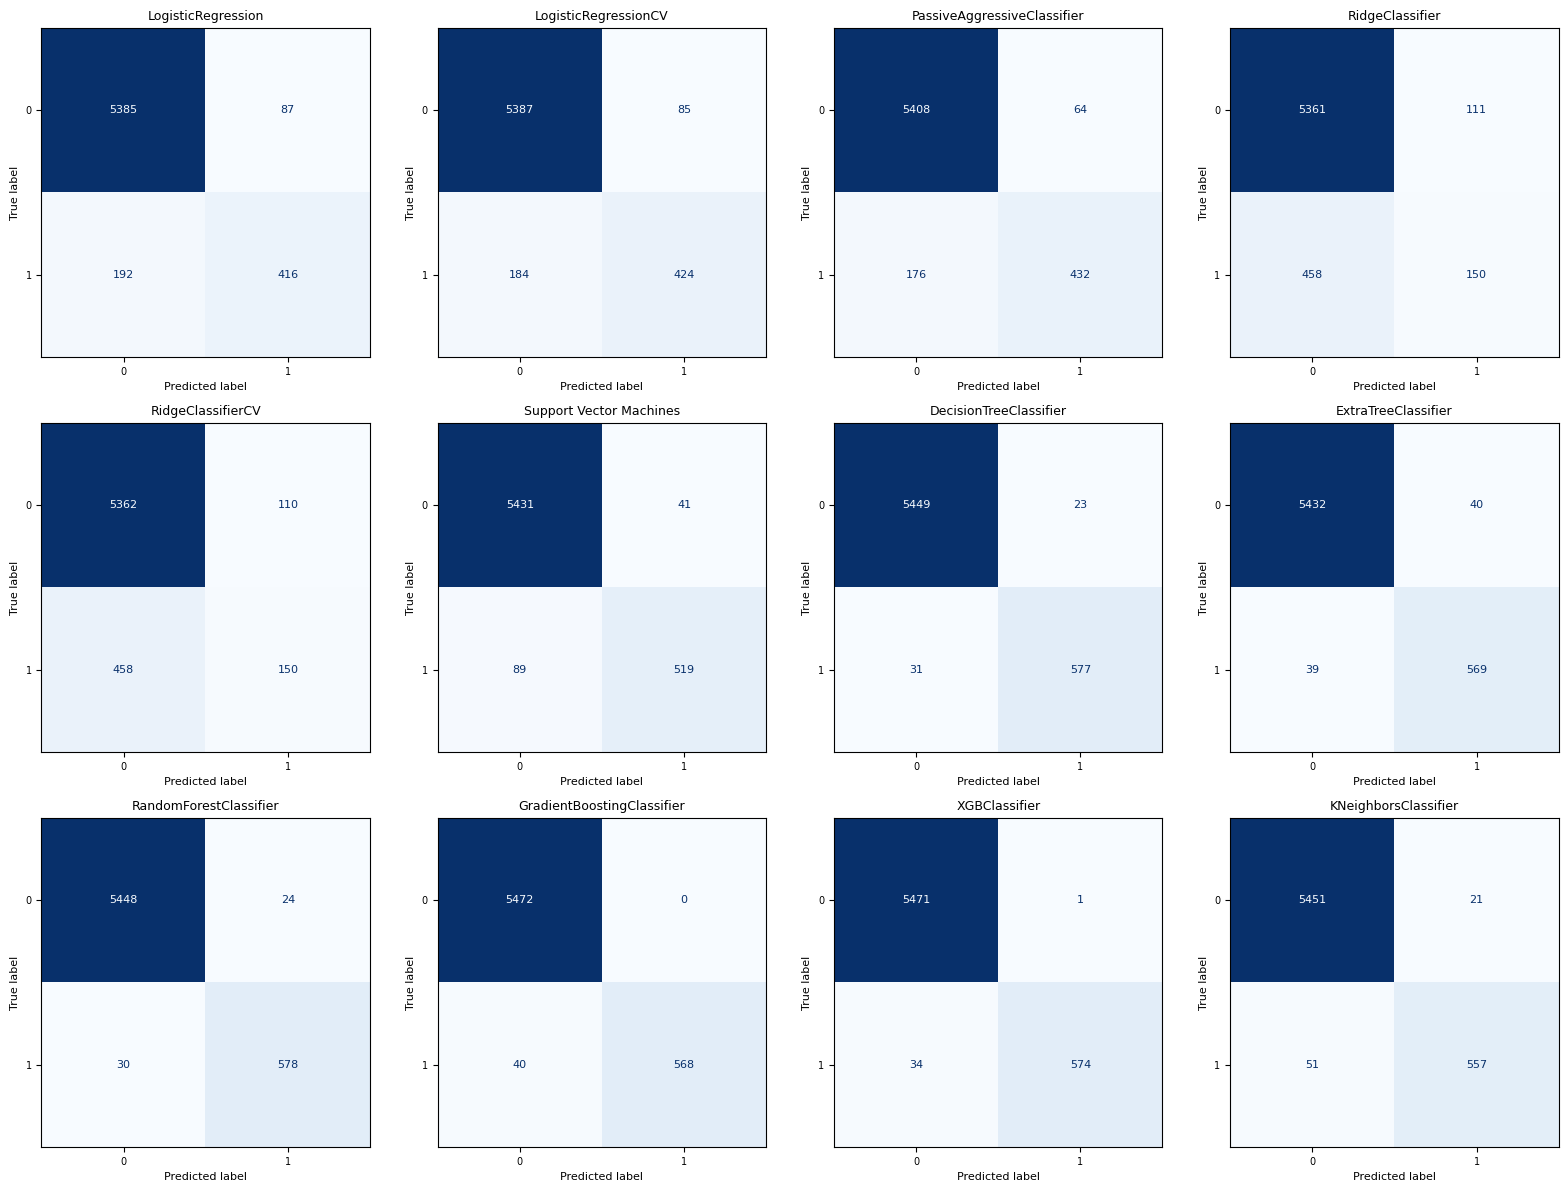

In [8]:
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

n_models = len(models)
cols = 4
rows = math.ceil(n_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[idx], cmap='Blues', colorbar=False, values_format='d')


    axes[idx].set_title(f'{name}', fontsize=9)
    axes[idx].set_xlabel('Predicted label', fontsize=8)
    axes[idx].set_ylabel('True label', fontsize=8)
    axes[idx].tick_params(axis='both', which='major', labelsize=7)
    for text in axes[idx].texts:
        text.set_fontsize(8)

    axes[idx].grid(False)

plt.tight_layout()
plt.show()
plt.close(fig)


# **ROC CURVE**

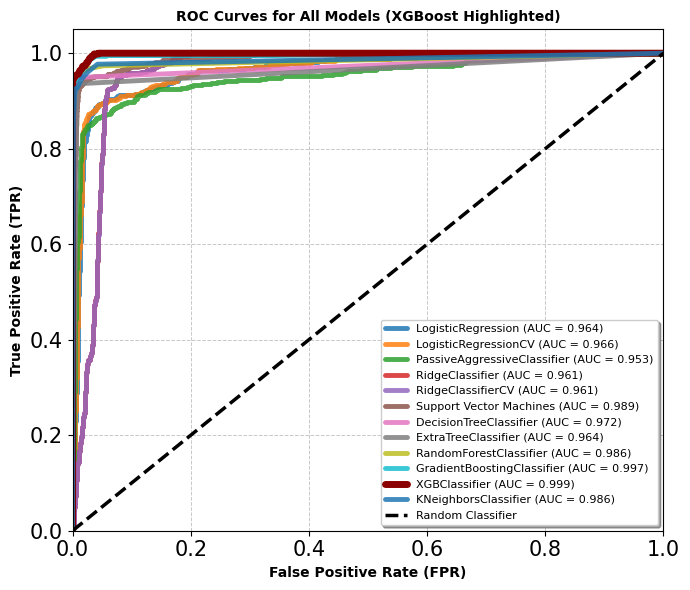

In [9]:

plt.figure(figsize=(7, 6))  # smaller figure, still good detail


for name, model in models.items():
    if hasattr(model, "predict_proba"):
        try:
            y_scores = model.predict_proba(X_test_scaled)[:, 1]
        except:
            continue
    elif hasattr(model, "decision_function"):
        try:
            y_scores = model.decision_function(X_test_scaled)
        except:
            continue
    else:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    if name == 'XGBClassifier':
        plt.plot(fpr, tpr, color='darkred', lw=5, linestyle='-',
                 label=f'{name} (AUC = {roc_auc:.3f})', solid_capstyle='round')
    else:
        plt.plot(fpr, tpr, lw=3.5, linestyle='-', alpha=0.85,
                 label=f'{name} (AUC = {roc_auc:.3f})', solid_capstyle='round')

plt.plot([0, 1], [0, 1], color='black', lw=2.5, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate (FPR)', fontsize=10, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=10, fontweight='bold')
plt.title('ROC Curves for All Models (XGBoost Highlighted)', fontsize=10, fontweight='bold')

plt.legend(loc="lower right", fontsize=8, frameon=True, shadow=True)

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()

plt.show()
plt.close()


# **EXPLICABILIDADE**

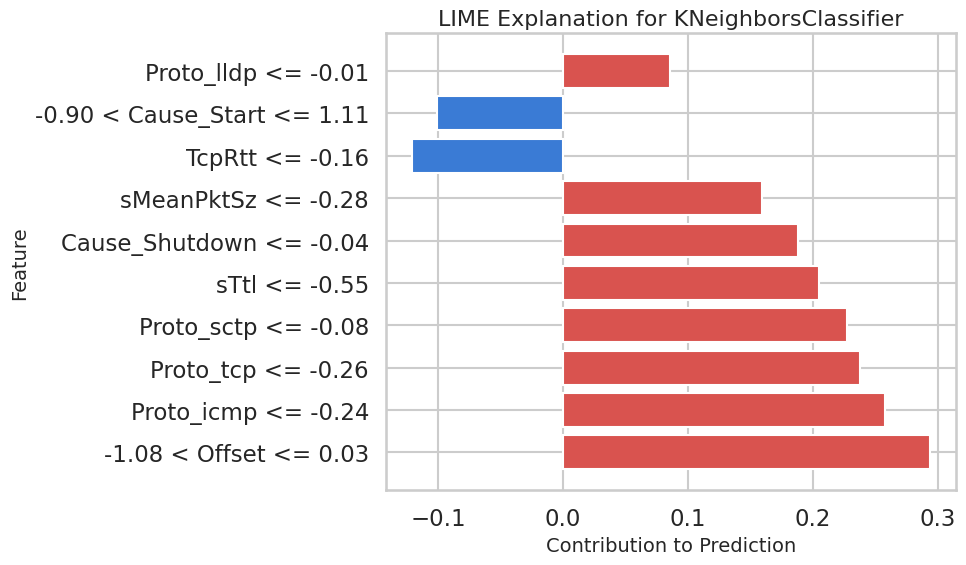

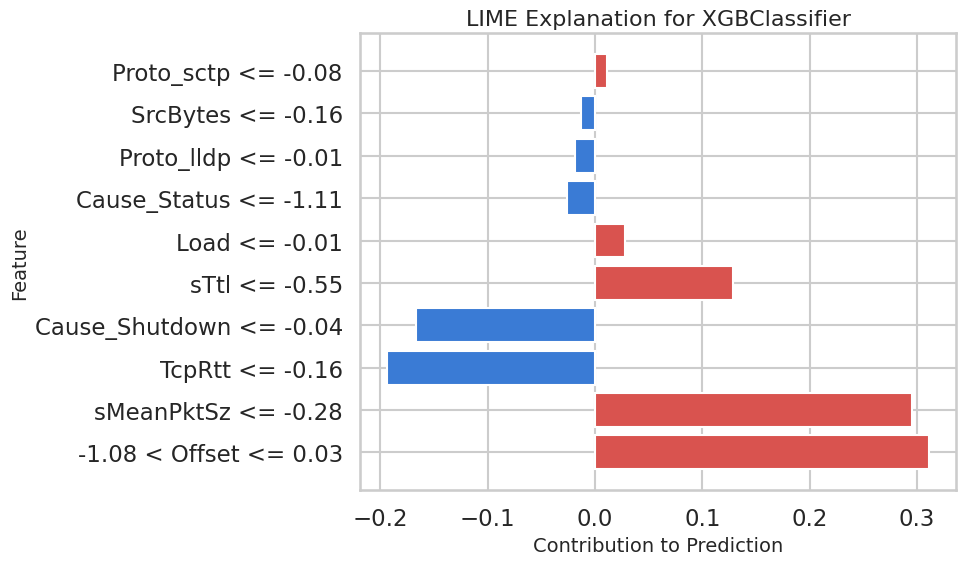

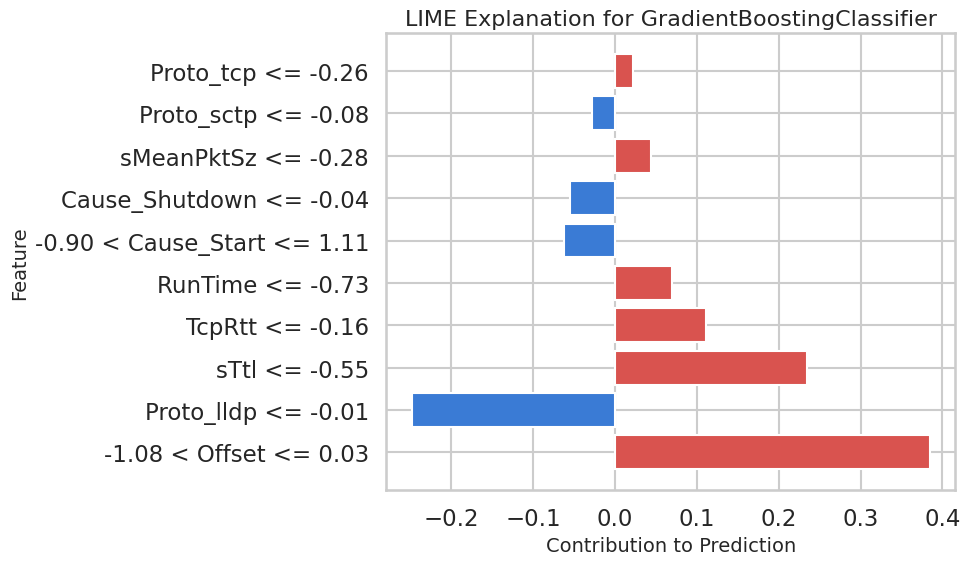

In [10]:
sns.set(style="whitegrid", context='talk')

selected_models = {
    'KNeighborsClassifier': models['KNeighborsClassifier'],
    'XGBClassifier': models['XGBClassifier'],
    'GradientBoostingClassifier': models['GradientBoostingClassifier']
}

feature_names = X_train_scaled_df.columns.tolist()

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled_df.values,
    feature_names=feature_names,
    class_names=['Benign', 'Malicious'],
    mode='classification',
    discretize_continuous=True
)

test_instance = X_test_scaled_df.iloc[0].values

for model_name, model in selected_models.items():
    if hasattr(model, "predict_proba"):
        predict_fn = model.predict_proba
    else:
        predict_fn = lambda x: np.array([model.predict(x)]).T

    exp = explainer_lime.explain_instance(
        data_row=test_instance,
        predict_fn=predict_fn,
    )

    # Retrieve feature contributions
    contribs = exp.as_list()
    features, weights = zip(*contribs)

    colors = ['#D9534F' if w > 0 else '#3A7BD5' for w in weights]

    # Start new figure for each model
    plt.figure(figsize=(10, 6))
    for i, (feature, weight, color) in enumerate(zip(features, weights, colors)):
        plt.barh(i, weight, color=color)
    plt.yticks(range(len(features)), features)
    plt.title(f'LIME Explanation for {model_name}', fontsize=16)
    plt.xlabel('Contribution to Prediction', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.show()
    plt.close()  # Close figure to avoid overlap with next
